# Tensorflow-gpu

TensorFlow-GPU is a specialized version of TensorFlow that takes advantage of the computational power of GPUs (Graphics Processing Units) to make deep learning faster and more efficient. It's designed for people who want to train and run deep learning models quickly. By using GPUs, TensorFlow-GPU can process data in parallel, which means it can handle large amounts of data much faster than regular TensorFlow. This makes it ideal for tasks like image recognition, language processing, and computer vision. With TensorFlow-GPU, you can tap into the full potential of your GPU and achieve better performance in your deep learning projects.

There are some issues with it though. With some hit and trial, I came to know that tensorflow-gpu v2.4.1 specifically requires the folllowing things.

- NVIDIA GPU with CUDA support.
- CUDA compiler (nvcc)
- cuDNN
- python 3.8 (not higher than that)
- numpy 1.19.5 (not higher than that)
- pandas 1.4.4 (compatible with numpy 1.19.5)

> **Note :** Newer versions of tf-gpu may be compatible with newer versions of python and numpy. But as of May 2023, these are the compatible versions. Just to be safe. I installed an older version of scikit-learn (0.23.2), as chat-gpt suggested.

Once all the necessary packages are installed, tensorflow-gpu works with the same NN scripts designed to work with regular GPU, but might need memory optimization. I don't know how to do that yet. (There is also something called 'pycuda' which acts like a bridge between a regular python script and the GPU. Learning cuda programming is actually not super necessary.)

Let's train a simple binary classifier using tf-gpu. Let's first check whether tg-gpu can detect the device or not. 

In [1]:
import tensorflow as tf
from warnings import filterwarnings
filterwarnings('ignore')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU(s) detected:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU detected. Using CPU for computation.")
    
print('Ready!')

2023-05-17 11:39:24.854056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


GPU(s) detected:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Ready!


2023-05-17 11:39:31.952407: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-17 11:39:31.957179: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-17 11:39:32.649915: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-17 11:39:32.676261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 119.24GiB/s
2023-05-17 11:39:32.676482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-17 11:39:32.768054: I tensorflow/stream_executor/platfor

Please ignore the warnings :)

# Preparing the dataframes

We have three text files in the `data` folder. They represent three different physics processes (TTZ, WZ and ZZ production at LHC). These are text files where each row represents an event and each column is a physics variable associated with the events. In this example I will train a neural network which will be able distinguish between WZ (let's call it a background process) and ZZ (let's call it a signal process). Let's import these text files as pandas dataframes and label them.

In [2]:
import pandas as pd

cols = [0,1,2,4,5,13,15,16,20,24,25,26] #Only reading these columns from the text files.
column_names = ['Pt0','Pt1','Pt2','NBJet','MET','MaxDphi_LMet','MaxDphi_LL','MinDphi_LL','LLPairPt','Mt0','Mt1','Mt2']
training_variables = column_names
#We are using all of the columns mentioned in this list.
#You can use a subset of them as well.

df_WZ = pd.read_csv('data/T3L_WZ.txt',sep=' ',index_col=None, usecols=cols,names=column_names)
df_ZZ = pd.read_csv('data/T3L_ZZ.txt',sep=' ',index_col=None, usecols=cols,names=column_names)

#We are going to combine these two dataframes into one, and scramble the rows before the training.
#To keep track of which event belongs to which, let's add a 'label' to them.

df_WZ['label']=0
df_ZZ['label']=1

#The goal of this exercise is to train a NN which takes the training variables and tries to predict this 'label'.
#We already know the labels. This is why this is a supervised learning.
#Later we can check how often the NN is right.

data = pd.concat([df_WZ,df_ZZ])
data = data.sample(frac = 1)

#The rows are now randomized.
#Now I'll split the events into two parts (70%, 30%).
#One part will go to the training and the other will be used for testing.

from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.3, stratify=data['label'])

#Let's split the columns into two parts, one containing the training variables and one containing the labels.
#We want these as numpy arrays.

X_train = data_train[training_variables].values
target_train = data_train['label'].values
#X_train are the inputs to the neural network, which is trying to predict target_train
#The prediction is compared with target_train, and a loss is calculated.
#This loss determines how the weights are adjusted.

X_test = data_test[training_variables].values
target_test = data_test['label'].values
#Once the training is done, the model is fixed.
#X_test goes through the NN and tries to predict target_test.
#This time there is no backpropagation.
#This time we are just checking what the prediction is.

#Let's print out some shapes.
print(f'The shape of the whole dataframe is {data.shape}')
print(f'The shape of X_train and target_train is {X_train.shape}, and {target_train.shape}')
print(f'The shape of X_test and target_test is {X_test.shape}, and {target_test.shape}')

The shape of the whole dataframe is (20000, 13)
The shape of X_train and target_train is (14000, 12), and (14000,)
The shape of X_test and target_test is (6000, 12), and (6000,)


In [3]:
#This is how the dataframe looks like.
some_columns = ['Pt0','Pt1','NBJet','MET','LLPairPt','Mt0']
data[some_columns].head

<bound method NDFrame.head of              Pt0        Pt1  NBJet        MET   LLPairPt         Mt0
165    76.934311  54.487537    0.0  34.717594  29.378317   63.865063
2640   49.551060  14.826100    0.0  90.684097  35.926796   71.280495
4691  183.649307  49.047367    0.0  49.550171  19.957935  204.156418
6890   62.507713  62.051064    0.0  27.913025  45.014408   45.464607
2370   42.901405  19.884613    0.0   9.652949  25.074739    4.549356
...          ...        ...    ...        ...        ...         ...
2653   39.235394  13.810624    0.0  55.033558  17.778364   88.455956
3265   35.929718  11.237221    0.0  30.537436  29.140961   53.585690
5820   58.970886  32.030872    0.0  12.409440  44.260262   18.834162
1648   40.387745  17.409369    0.0  36.659042  23.903421   55.877495
1466   50.157909  35.288574    0.0   7.130816  57.533325   13.987385

[20000 rows x 6 columns]>

# Plotting inputs

### ALWAYS look at the input variables before training.

I am plotting only a few variables here.

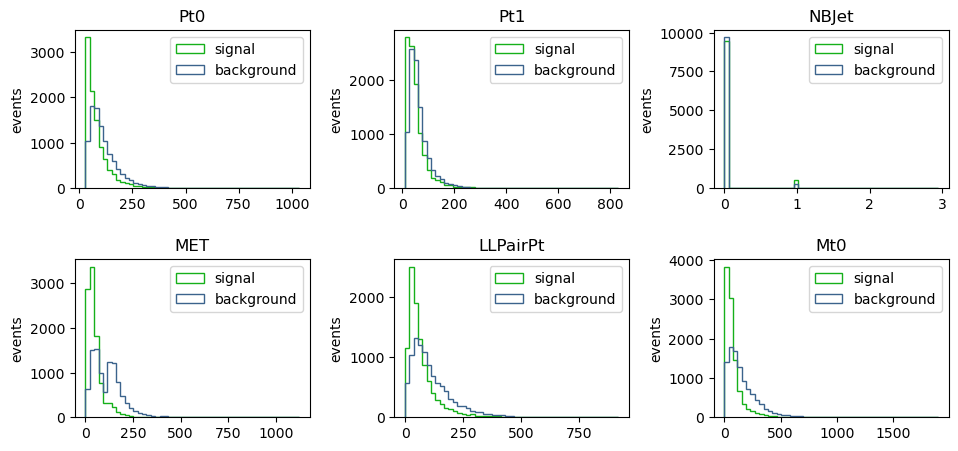

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff()
#prevents automatic figure displays
import numpy as np

fig0, ax0 = plt.subplots(2,3,figsize=(10,5))
fig0.tight_layout(pad=3.0)
ax0 = ax0.flatten()

for i in range(len(some_columns)):
    varname = some_columns[i]
    xmin = min(data[varname].values.tolist())
    xmax = max(data[varname].values.tolist())

    if xmax!=xmin :
        stepsize = (xmax-xmin)/50
        bins_=np.arange(xmin, xmax, stepsize)
    else :
        bins_ = np.arange(0, 10, 1)
    
    ax0[i].hist(data[data['label']==1][varname], bins=bins_, color='xkcd:green', histtype='step', label='signal')
    ax0[i].hist(data[data['label']==0][varname], bins=bins_, color='xkcd:denim', histtype='step', label='background')
    ax0[i].set_title(varname)
    ax0[i].set_ylabel('events')
    ax0[i].legend(loc='upper right')
    
plt.show()

For a NN to learn how to distinguish between these two classes of events, it needs input features which are different from each other. Identical features contribute less towards the training and can be avoided. In this case, for example, the number of bJets is not a good varible to distinguish between WZ and ZZ. We can remove this from the training. We can also introduce new variable with better separation. Adding varibles which are correlated to the already chosen variables also does not help much.

Also, as you can see, the input variables have very different ranges. In such cases, the larger numbers may affect the training more. However, we want the NN learn from the shapes, and not from the range of values these variable takes (or, the unit system we are using). That's why, all variables are needed to be scaled.

# Scaling the variables

I am defining a min-max scalar here. All the variables are scaled from -1 to 1 before going into the training. Some people also like to use standard deviation scalar, where all the plots are scaled in such a way that the standard deviations are 1. Min-max scalar can be used when the distributions are faily disributed in some local region, and there is not a weird anomaly far away. (otherwise the far away point would dramatically affect the scaling). For this example, min-max scalar is good enough.

In [5]:
def minmaxscalar(array): 
    maxValues = array.max(axis=0) #column
    minValues = array.min(axis=0)
    #Save these normalisation parameters along with the model for later use.
    MaxMinusMin = maxValues - minValues
    normed_array = 2*((array - minValues)/(MaxMinusMin)) -1.0
    return normed_array

X_train = minmaxscalar(X_train)
X_test = minmaxscalar(X_test)

print('The training variables are normalised between -1 and 1.')
#print(f'The shape of X_train and target_train is {X_train.shape}, and {target_train.shape}')
#print(f'The shape of X_test and target_test is {X_test.shape}, and {target_test.shape}')

The training variables are normalised between -1 and 1.


# Defining the model

Choosing a neural network architecture involves some trial and error. It also depends on how computationally difficut it is or what the dataset is. I am going with a simple NN with 4 hidden layes. It may or may not give me the best performance. I can always come back, tweak some parameters and choose the one that works for me. This reminds me of a comic by xkcd.

![Machine Learning](https://imgs.xkcd.com/comics/machine_learning.png)

In [6]:
#importing the packages:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

#Also removing the warnings (optional)
from warnings import filterwarnings
filterwarnings('ignore')

n_features = X_train.shape[1]
print(f'The number of input variables is {n_features}')

model = Sequential()
model.add(Dense(256, activation='relu', kernel_initializer='he_normal', input_dim=n_features))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print('The model is compiled and ready for training.')

The number of input variables is 12


2023-05-17 11:39:36.422456: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 11:39:36.424340: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-17 11:39:36.425439: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-17 11:39:36.425517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 119

The model is compiled and ready for training.


Understanding some of the parameters in this model:
- **`activation = 'relu'`** : It refers to the rectified linear unit activation function used to 'active' a neuron. It sets negative values to zero and keeps positive values unchanged.

- **`kernel_initializer = 'he_normal'`** : It represents the 'He normal initializer', which initializes the weights of the neural network layers using a normal distribution with a variance proportional to the number of input units. (The weights are initially just random numbers. This is one way to initialize them.)

- **`optimizer = 'adam'`** : This is one of the adaptive learning rate optimization algorithm. This is used to take appropriate steps towards the minimum value of the loss function during backpropagation.

- **`loss = 'binary_crossentropy'`** : It signifies the binary cross-entropy loss function, commonly used for binary classification problems.

- **`metrics = ['accuracy']`** : It specifies that accuracy is used as the evaluation metric to assess the performance of the neural network model during training and testing phases. (I don't know what is means. ChatGPT wrote it.)


# Training

After compiling the model, we are ready to train the model with `X_train`. This is what some of the training parameters mean.
- **`epochs = 20`** : It represents the number of times the entire dataset is passed forward and backward through the neural network during the training process. In this case, it is 20. If the loss function stops reducing after some umber of epochs, we can stop the training after that many epochs. Also, having a very high number of epochs may result in 'over-training', which is often indicated by a disagreement between training and testing accuracy plots.

- **`batch_size = 512`** : It is the number of training examples used in a single iteration or update of the neural network's parameters. It affects the memory usage and computational efficiency during training.

- **`verbose = 0`** : It controls the amount of information displayed during the training process. In this case, no output will be displayed.

In [7]:
#The following line is training the model
history = model.fit(X_train,target_train,epochs=20,batch_size=512,validation_data=(X_test,target_test),verbose=0)

print('The model is trained.')

2023-05-17 11:39:39.806324: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-17 11:39:39.807020: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400005000 Hz
2023-05-17 11:39:40.406464: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


The model is trained.


In [8]:
print('The NN architecture is')
model.summary()

The NN architecture is
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               3328      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 20,833
Trainable params: 20,833
Non-trainable params: 0
_________________________________________________________________


In [9]:
#Checking loss and acuuracy

#The following two arrays are accuracy as a function of epoch
accuracy_train = history.history['accuracy']
accuracy_test = history.history['val_accuracy']

#The following two arrays are loss as a function of epoch
loss_train = history.history['loss']
loss_test = history.history['val_loss']

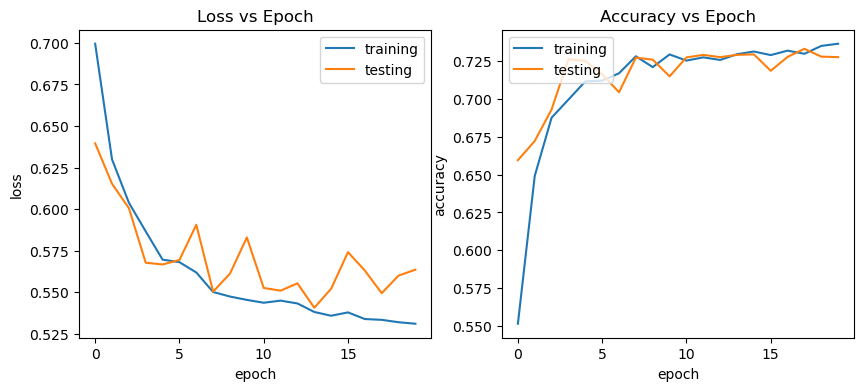

In [10]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax = ax.flatten()

ax[0].plot(loss_train, label='training')
ax[0].plot(loss_test, label='testing')
ax[0].set_title('Loss vs Epoch')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend(loc='upper right')

ax[1].plot(accuracy_train, label='training')
ax[1].plot(accuracy_test, label='testing')
ax[1].set_title('Accuracy vs Epoch')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend(loc='upper left')

plt.show()

The loss 'kind of' saturates around 20 epochs, so I guess this is okay.

# Testing

The following part can be done in a different script also, if you have saved the model first. Once you have the model and the min-max scaling parameters, you can always try predicting the 'label' (whether it is signal or background). The prediction is a number between 0 and 1. All the events in `X_train` and `X_test` has a 'true' label (which we knew beforehand) and a 'predicted' label (calculated by the NN).

In [11]:
#The following two arrays contain the predicted 'labels'.
#The first one was used to calculate loss, while the second is is jost for testin, after the model is frozen
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

#Let's put them into dataframes, so that plotting is easier.
df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train['truth'] = target_train
df_train['predicted'] =  predicted_train

df_test['truth'] = target_train
df_test['predicted'] =  predicted_train

Since we have arrays of 'true' and 'predicted' numbers, we can decide a threshold on the predicted numbers. If a particular event has a predicted number greater than the threshold, it can be treated as a signal event, and vice versa. Of course a background event (with true label=0) may occasionaly categorized as a signal event, or the other way around. So the choice of the threshold introduces some 'efficiecy', representing how good the classification is. We often express the efficiencies in terms of the following parameters.
- **True Positive Rate (Signal Efficiency)**  measures how well a model identifies actual signal events correctly. It is the ratio of true positives to the sum of true positives and false negatives.
$$\text{TPR} = \frac{\text{Number of signal events that passes the selection}}{\text{Number of any event (sig+bkg) that passes the selection}}$$<br>
- **False Negative Rate (Background Rejection)** is the proportion of actual positive cases that are incorrectly classified as negative. It is the ratio of false negatives to the sum of true positives and false negatives. FNR represents the rate at which positive instances are mistakenly labeled as negative.<br>

$$\text{FNR} = \frac{\text{Number of rejected background events}}{\text{Number of any rejected events}}$$<br>

These two efficiencies depend on the threshold we have chosen on the predicted number to classify the two different types of events. There is a nice way to visualize all the TPR and FNR that is associated with all the possible choices of this threshold - a **ROC (Receiver Operating Characteristic) curve**.

In [12]:
#ROC calculation
from sklearn.metrics import roc_curve,auc

#For training data
fpr, tpr, _ = roc_curve(target_test,predicted_test)
auc_score = auc(tpr,1-fpr)

#for testing data
fpr1, tpr1, _ = roc_curve(target_train,predicted_train)
auc_score1 = auc(tpr1,1-fpr1)

#In terms of percentages:
tpr=tpr*100
fnr=(1-fpr)*100
tpr1=tpr1*100
fnr1=(1-fpr1)*100

# Plotting

In [13]:
import numpy as np
plt.ioff()

# For the NN score plot
#Choose a binning scheme
mybins = np.arange(0, 1.02, 0.02)

#define the histograms.
#Let's call ZZ as signal (label ==1) and WZ as background (label==0)

#hist_sig = taking the signal part of the df (where truth==1) and picking the predicted values.
hist_sig = plt.hist(df_test[df_test['truth']==1]['predicted'],bins=mybins, density=False)

#hist_bkg = taking the background part of the df (where truth==0) and picking the predicted values.
hist_bkg = plt.hist(df_test[df_test['truth']==0]['predicted'],bins=mybins, density=False)

#Let's calculate the errors associated with these histograms.
hist_sig_err = np.sqrt(hist_sig[0])
hist_bkg_err = np.sqrt(hist_bkg[0])

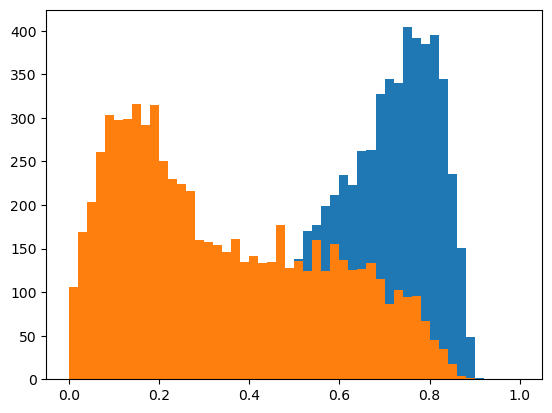

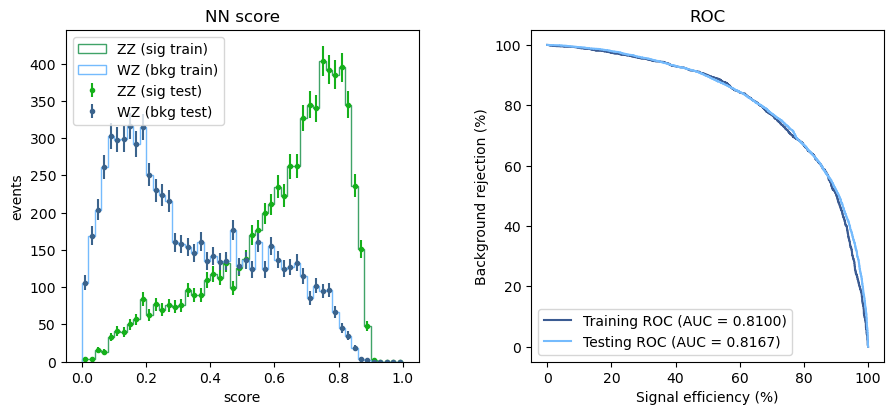

In [14]:
plt.ioff()
fig1, ax1 = plt.subplots(1,2,figsize=(10,5))
fig1.tight_layout(pad=5.0)
ax1 = ax1.flatten()

#NN SCORE PLOT
#Plotting the testing dataset with errorbars
ax1[0].errorbar(hist_sig[1][1:]-0.01, hist_sig[0], yerr=hist_sig_err, fmt='.', color='xkcd:green', label='ZZ (sig test)')
ax1[0].errorbar(hist_bkg[1][1:]-0.01, hist_bkg[0], yerr=hist_bkg_err, fmt='.', color='xkcd:denim', label='WZ (bkg test)')

#Plotting the training dataset as welll (just to compare, as simple histograms)
ax1[0].hist(df_train[df_train['truth']==1]['predicted'], bins=mybins, histtype='step', color='xkcd:greenish', label="ZZ (sig train)", density=False,log=False)
ax1[0].hist(df_train[df_train['truth']==0]['predicted'], bins=mybins, histtype='step', color='xkcd:sky blue', label="WZ (bkg train)", density=False,log=False)

#decorations:
ax1[0].set_title('NN score')
ax1[0].set_xlabel('score')
ax1[0].set_ylabel('events')
ax1[0].legend(loc='upper left')

#ROC
ax1[1].plot(tpr, fnr, color='xkcd:denim blue', label=f'Training ROC (AUC = {auc_score:.4f})')
ax1[1].plot(tpr1, fnr1, color='xkcd:sky blue', label=f'Testing ROC (AUC = {auc_score1:.4f})')
ax1[1].set_title('ROC')
ax1[1].set_xlabel('Signal efficiency (%)')
ax1[1].set_ylabel('Background rejection (%)')
ax1[1].legend(loc='lower left')

plt.show()

By looking at the ROC (right), we can choose a working point on the curve, which corresponds to a particular threshold on the NN score plot (left). 